# 폐렴을 진단하기

In [17]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [18]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 실험환경 Set-up 변경 적용
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 가져오기

- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

#### 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옴
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [19]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [20]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


---
# 정상 이미지 vs 폐렴 이미지 데이터 구분하기
- 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지
- 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지

In [21]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [22]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [23]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 1) 라벨 데이터 (정상, 폐렴 구분하는 데이터) 만드는 함수

In [24]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2) 이미지 데이터 사이즈 통일시키기

In [25]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [26]:
print('# Train Dataset >>>>>>>>>>>>>>>> ')

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

    
print('\n# Test Dataset >>>>>>>>>>>>>>>> ')

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

# Train Dataset >>>>>>>>>>>>>>>> 
Image shape:  (180, 180, 3)
Label:  False

# Test Dataset >>>>>>>>>>>>>>>> 
624


### 3) 데이터 시각화 함수

In [27]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

### 4) ***NEW*** 데이터 변환 + 좌우 반전 정도의 augmentation 도입

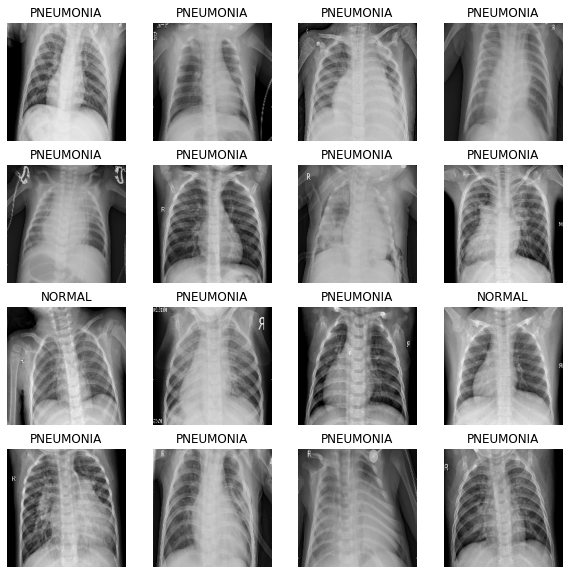

In [28]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 변환 후 확인 (시각화)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

##### ✔️ 무작위로 좌우 반전 처리되어 일부 사진의 "R"이 왼쪽에 위치한 것을 확인할 수 있습니다.

---

# 모델링1 

### 실험환경 변경
1. epoch : 10 / batch_size : 16 -> 84%
2. epoch : 10 / batch_size : 13 -> 76%
3. epoch : 10 / batch_size : 19 -> 68%
4. epoch : 10 / batch_size : 16 -> (again) 71%
5. **epoch : 25 / batch_size : 16 -> 85%**

```
실험환경을 변경해본 결과,
batch_size를 크게 혹은 적게 변경하면 더 정확도가 떨어졌으며
epoch를 줄인 것이 정확도에 영향을 주미 못하는 것을 확인했습니다. 
따라서 실험환경은 노드 학습할 때 값인 "epoch : 25 / batch_size : 16"로 진행하였습니다
```

### 데이터 imbalance 처리

In [29]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 설계 (기본)

In [156]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


### 모델 훈련

In [157]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 188ms/step - loss: 0.3754 - accuracy: 0.8111 - precision: 0.9559 - recall: 0.7820 - val_loss: 0.6760 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2181 - accuracy: 0.9167 - precision: 0.9745 - recall: 0.9118 - val_loss: 1.0041 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.2216 - accuracy: 0.9155 - precision: 0.9713 - recall: 0.9134 - val_loss: 0.1109 - val_accuracy: 0.9519 - val_precision: 0.9452 - val_recall: 0.9922
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1600 - accuracy: 0.9368 - precision: 0.9820 - recall: 0.9320 - val_loss: 0.6590 - val_accuracy: 0.7567 - val_precision: 0.7517 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1776 - accura

### 모델 평가

39/39 [==============================] - 4s 105ms/step - loss: 0.5001 - accuracy: 0.8526 - precision: 0.8356 - recall: 0.9513
Loss: 0.5000593066215515,
Accuracy: 0.8525640964508057,
Precision: 0.8355855941772461,
Recall: 0.9512820243835449


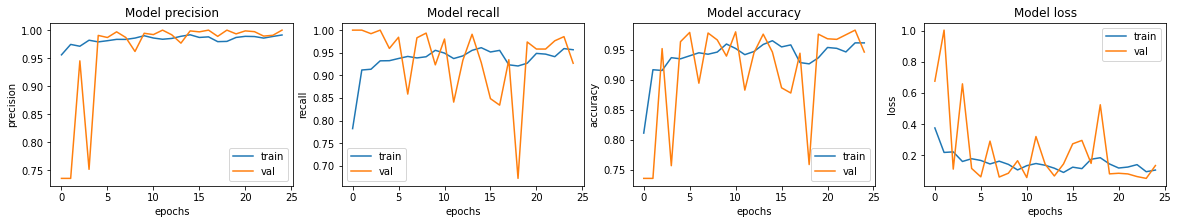

In [158]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

---

# 모델링2
- epoch를 25, batch_size 16 (모델링1 결과 적용)
- 폐렴 진단에서 중요한 accuracy와 recall을 위주로 함께 고려
    - 정확도 : 폐렴을 얼마나 잘 (True Positive + True Negative) 진단했는지
    - Recall : 폐렴(양성)인 사람들을 얼마나 잘 찾아냈는지
- 실험 단계 계획
    1. 없는 것보다 있는게 나을지, 1개보단 여러개가 나을지 확인
    2. conv_block 별도, dense_block 별도로 적용
        - 수치값을 동일하게
        - 수치값을 조금씩 다르게
    3. conv_block, dense_block 전반적으로 부분적으로 적용
    4. 모두 적용


### 1. Dropout을 모두 제거하여 실험
- Dropout 사용안함
- 78%
    

### 2. conv_block에 Dropout을 다양하게 적용
1. conv_block 레이어 마지막에만 하나 적용(0.2) : 1개는 성능이 너무 안좋음
    - Loss: 2.609088659286499,
    - Accuracy: 0.6634615659713745,
    - Precision: 0.6505016684532166,
    - Recall: 0.9974358677864075
2. conv_block 레이어 중간과 마지막에 하나씩 적용(0.2) : 1개보단 2개가 나음, 그러면 더 적용?
    - Loss: 1.3772051334381104,
    - Accuracy: 0.7467948794364929,
    - Precision: 0.7132353186607361,
    - Recall: 0.9948717951774597
3. conv_block 세개 적용(0.2) : 2개나 3개나 차이가 크지 않음, 더 하면 좋아질까?
    - Accuracy: 0.7532051205635071,
    - Precision: 0.7185184955596924,
    - Recall: 0.9948717951774597
4. conv_block 모두다 적용(0.2) : 4개(모두)적용했더니 성능이 좋아짐
    - Loss: 3.179903745651245,
    - Accuracy: 0.6810897588729858,
    - Precision: 0.6638078689575195,
    - Recall: 0.9923076629638672
    ```
    Loss, Accuracy그리고 Recall값을 보아, Overfit이 발생했다고 판단하여, epoch를 13으로 변경 후 다시 실행
    ```
    - Loss: 1.0278164148330688,
    - Accuracy: 0.7900640964508057,
    - Precision: 0.7504835724830627,
    - Recall: 0.9948717951774597
5. conv 모두다 적용(0.2-0.3-0.4-0.5) : 4개(모두) + dropout값을 (올리는방식으로) 바꿔보면 쓸모없음
    - Loss: 1.0622055530548096,
    - Accuracy: 0.7580128312110901,
    - Precision: 0.7225325703620911,
    - Recall: 0.9948717951774597
6. ⭐️ conv 모두다 적용(0.5-0.4-0.3-0.2)
    - Loss: 0.8610851764678955,
    - Accuracy: 0.7996794581413269,
    - Precision: 0.7592955231666565,
    - Recall: 0.9948717951774597

### 3. dense_block에 Dropout을 다양하게 적용
1. dense_block 마지막에 하나만 적용 : 
    - Loss: 1.5114591121673584,
    - Accuracy: 0.7243589758872986,
    - Precision: 0.6953405141830444,
    - Recall: 0.9948717951774597
2. ⭐️ dense_block 모두 0.2로 적용 : 하나만 적용한 것 보다 더 수치 값이 좋음
    - Loss: 0.8666902184486389,
    - Accuracy: 0.7964743375778198,
    - Precision: 0.7593688368797302,
    - Recall: 0.9871794581413269
3. dense_block 모두 적용 + 값을 다르게 지정해서 (0.2,0.3,0.4) : 더 안좋아짐
    - Loss: 1.305867314338684,
    - Accuracy: 0.7708333134651184,
    - Precision: 0.7379575967788696,
    - Recall: 0.9820512533187866
4. dense_block 모두 적용 + 값을 다르게 지정해서 (반대로 0.7,0.5,0.3) : 
    - Loss: 1.3178322315216064,
    - Accuracy: 0.7644230723381042,
    - Precision: 0.7305502891540527,
    - Recall: 0.9871794581413269

### 4. 전반적으로 Dropout을 다양하게 적용
1. Dense와 Conv각각에 결과가 좋았던 것 기준으로 모두 적용
    - Loss: 0.5270710587501526,
    - Accuracy: 0.8541666865348816,
    - Precision: 0.8421052694320679,
    - Recall: 0.9435897469520569
    또는
    - Loss: 0.6945912837982178,
    - Accuracy: 0.7467948794364929,
    - Precision: 0.714022159576416,
    - Recall: 0.9923076629638672




### 모델 설계 변경

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(64),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        dense_block(512),
        tf.keras.layers.Dropout(0.2),
        dense_block(128),
        tf.keras.layers.Dropout(0.2),
        dense_block(64),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


### 모델 훈련

In [31]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 188ms/step - loss: 0.5012 - accuracy: 0.7311 - precision: 0.9217 - recall: 0.6977 - val_loss: 0.6229 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2927 - accuracy: 0.8740 - precision: 0.9598 - recall: 0.8672 - val_loss: 1.4549 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.2420 - accuracy: 0.9021 - precision: 0.9678 - recall: 0.8983 - val_loss: 0.4659 - val_accuracy: 0.7894 - val_precision: 0.7772 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2378 - accuracy: 0.9068 - precision: 0.9709 - recall: 0.9019 - val_loss: 0.1163 - val_accuracy: 0.9529 - val_precision: 0.9431 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2191 - accura

### 모델 평가

39/39 [==============================] - 4s 108ms/step - loss: 0.6946 - accuracy: 0.7468 - precision: 0.7140 - recall: 0.9923
Loss: 0.6945912837982178,
Accuracy: 0.7467948794364929,
Precision: 0.714022159576416,
Recall: 0.9923076629638672


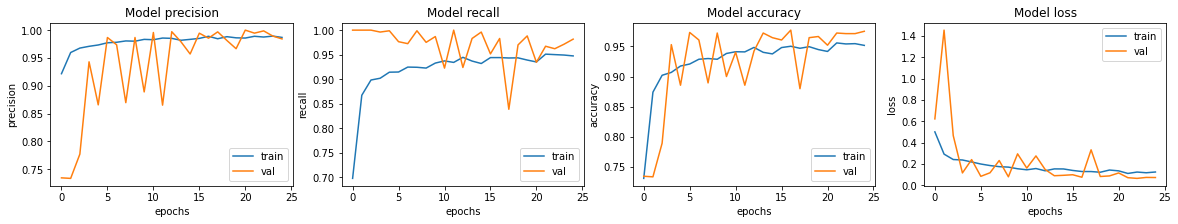

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

---

# 회고

### 1. 어려웠던 점 혹은 아직 모호한 점
- 모델 설계를 실험환경 세팅을 바꿔보는데 기본적인 개념의 이해가 부족해서 그런지, 어떻게 해야 할지 감을 잡기가 어려웠습니다.
- 아직 Dropout이나 Batch Normalization을 왜 이 시점에 적용하는지 이해가 안됩니다 (눈으로 확인이 안되는 상황에 이걸 적용해서 어떻게 된다는것..?)


### 2. 시도한 것들
1. 그래서 기본적인 환경셋팅부터 테스트해봤습니다. 
    - epoch와 batch_size가 훈련에 어떤 영향을 미치는지 확인해보았고,
    - 역시 아이펠 노드에 있는 기본 세팅이 가장 좋은 세팅이구나를 느낄 수 있었습니다.
2. 두번째로는 Dropout에 집중해서 테스트를 해봤습니다.
    - Dropout이 (설정한 값만큼) "과적합을 막기 위한 정규화 기법"이라는 것에 집중해서, 과적합이 생길만한 부분이 어디일지 생각해봤습니다.
    - Conv와 Dense를 여러번하는 부분에서 역시 과적합이 생기지 않을까.. 추측을 해보면서 어떻게 설정하면 좋을지 실험계획을 세워 차례대로 진행했습니다.
    - 성능 상 두드러진 개선을 찾진 못했습니다.


### 3. 자기 다짐
```
개념에 더 집중해서 학습을 해야겠습니다.
```